# Description

The notebook shows how to perform time series prediction using the Prophet model develop by Facebook.

References:
- White paper: `https://peerj.com/preprints/3190.pdf`
- Official docs: `https://facebook.github.io/prophet/docs/quick_start.html`

# Imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prophet as prh
import prophet.utilities as prhu
import scipy.stats as stats

import helpers.hprint as hprint
import helpers.hdbg as hdbg
import helpers.hpandas as hpanda

In [4]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.12/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-8e773bf3-9049-4049-96f9-b65ed5461357.json'


ModuleNotFoundError: No module named 'seaborn'

# Config

In [6]:
config = {
    # Train/test split.
    "train_start_date": "2020-01-01",
    "train_end_date": "2023-12-31",
    "test_start_date": "2024-01-01",
    "test_end_date": "2024-12-31",
    "data": {
        # Linear trend params.
        "slope": 0.005,
        "intercept": 15,
        # Fourier term params for seasonality component.
        "weekly_amp_sin": 5.0,
        "weekly_amp_cos": 2.5,
        # List of holidays and their impact.
        "holidays_dates": ['2020-12-25', '2021-12-25', '2022-12-25', "2023-12-25", "2024-12-25"],
        "holidays_impact": 2.5,
        # Autoregression params.
        "ar_order": 1,
        "phi": 0.7,
        # Noise std.
        "seed": 42,
        "noise_sigma": 2.0,
    },
    "model": {
        # Defines trend shape.
        "growth":"linear", 
        "yearly_seasonality":False, 
        # Integer defines Fourier order.
        "weekly_seasonality":1, 
        "daily_seasonality":False, 
        "n_changepoints":0, 
        # Prophet internally scales the target variable.
        "scaling":"minmax", 
        # Confidence iterval width.
        "interval_width":0.95,
        # Number of MCMC samples; If `mcmc_samples = 0`, the model produces just a point estimate  of each
        # parameter instead of the full distribution.
        "mcmc_samples":300,
        # Set lower prior scale to narrow the confidence interval.
        "holidays_prior_scale":1,
    },
}
print(config)

{'train_start_date': '2020-01-01', 'train_end_date': '2023-12-31', 'test_start_date': '2024-01-01', 'test_end_date': '2024-12-31', 'data': {'slope': 0.005, 'intercept': 15, 'weekly_amp_sin': 5.0, 'weekly_amp_cos': 2.5, 'holidays_dates': ['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25'], 'holidays_impact': 2.5, 'ar_order': 1, 'phi': 0.7, 'seed': 42, 'noise_sigma': 2.0}, 'model': {'growth': 'linear', 'yearly_seasonality': False, 'weekly_seasonality': 1, 'daily_seasonality': False, 'n_changepoints': 0, 'scaling': 'minmax', 'interval_width': 0.95, 'mcmc_samples': 300, 'holidays_prior_scale': 1}}


# Generate data

In [7]:
# Generate date range.
dates = pd.date_range(start=config["train_start_date"], end=config["test_end_date"], freq='D')
time = np.arange(len(dates))
# Define linear trend.
y_trend = config["data"]["slope"] * time + config["data"]["intercept"]
# Define the seasonality factor.
p_weekly = 7
y_weekly_seasonality = config["data"]["weekly_amp_sin"] * np.sin(2 * np.pi * time / p_weekly) + config["data"]["weekly_amp_cos"] * np.cos(2 * np.pi * time / p_weekly)
# Define holidays impact.
holiday_effect = np.zeros(len(dates))
holiday_effect[np.isin(dates.date, pd.to_datetime(config["data"]["holidays_dates"]).date)] = config["data"]["holidays_impact"]
# Define white noise.
np.random.seed(config["data"]["seed"])
noise = np.random.normal(loc=0, scale=config["data"]["noise_sigma"], size=len(time))
# Add autoregressive behavior.
y = np.zeros(len(time))
y[0] = y_trend[0] + y_weekly_seasonality[0] + holiday_effect[0] + noise[0]
for i in range(1, len(time)):
    y[i] = config["data"]["phi"] * y[i-1] + y_trend[i] + y_weekly_seasonality[i] + holiday_effect[i] + noise[i]
df = pd.DataFrame({"ds": dates, "y": y})
# Add lagged value of the target as a feature.
df["y.lag1"] = df["y"].shift(1)
# The first row is NaN -> drop it.
df = df.dropna()
_LOG.info(hpanda.df_to_str(df, log_level=logging.INFO))

,ds,y,y.lag1
1,2020-01-02 00:00:00,33.141753,18.493428
2,2020-01-03 00:00:00,43.822941,33.141753
3,2020-01-04 00:00:00,48.654115,43.822941
,...,...,...
1824,2024-12-29 00:00:00,78.387492,83.360033
1825,2024-12-30 00:00:00,74.449184,78.387492
1826,2024-12-31 00:00:00,71.713198,74.449184


INFO  None


<Axes: title={'center': 'Original data'}, xlabel='Time', ylabel='Target variable'>

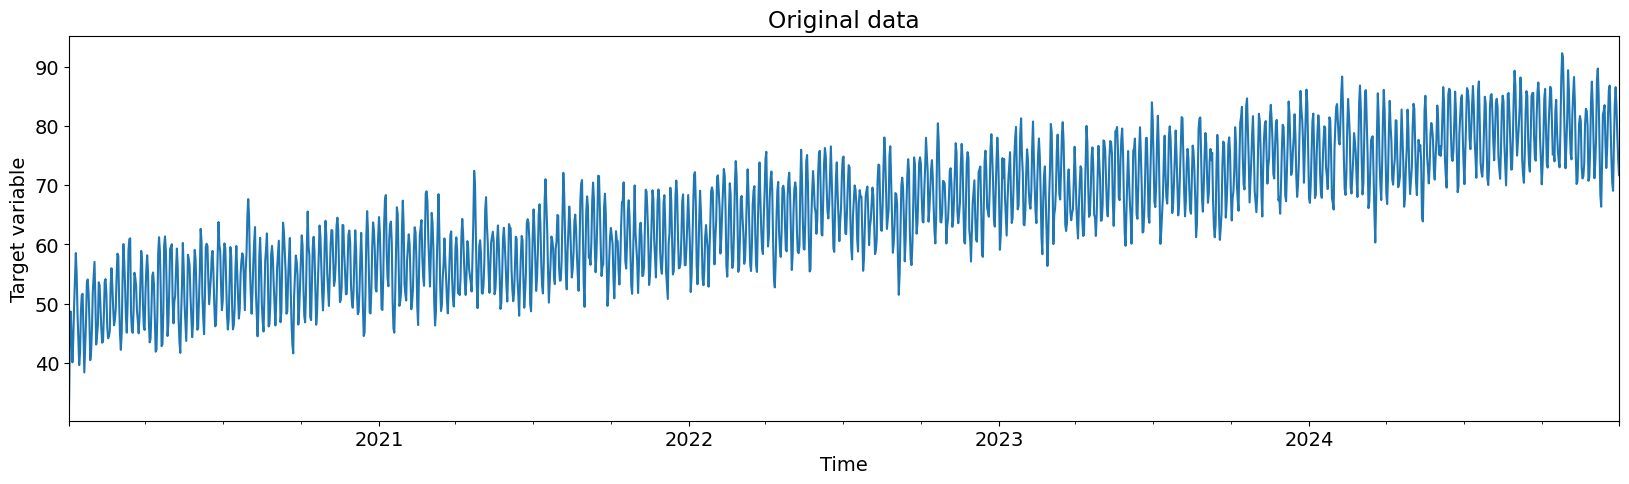

In [8]:
df.set_index("ds")["y"].plot(title="Original data", ylabel="Target variable", xlabel="Time")

# Fit the model

In [75]:
start_date_filter = df["ds"] >= config["train_start_date"]
end_date_filter = df["ds"] <= config["train_end_date"]
df_train = df[start_date_filter & end_date_filter]
_LOG.info(hpanda.df_to_str(df_train, log_level=logging.INFO))

,ds,y,y.lag1
1,2020-01-02 00:00:00,33.141753,18.493428
2,2020-01-03 00:00:00,43.822941,33.141753
3,2020-01-04 00:00:00,48.654115,43.822941
,...,...,...
1458,2023-12-29 00:00:00,86.189145,81.430431
1459,2023-12-30 00:00:00,83.89076,86.189145
1460,2023-12-31 00:00:00,76.324779,83.89076


INFO  None


In [10]:
# Construct a Dataframe with holidays.
holidays_df = pd.DataFrame({
    'holiday': ['Christmas 2020', 'Christmas 2021', 'Christmas 2022', "Christmas 2023", "Christmas 2024"],
    'ds': pd.to_datetime(config["data"]["holidays_dates"]),
    'lower_window': 0, 
    'upper_window': 0,   
})
_LOG.info(hpanda.df_to_str(holidays_df, log_level=logging.INFO))

,holiday,ds,lower_window,upper_window
0,Christmas 2020,2020-12-25,0,0
1,Christmas 2021,2021-12-25,0,0
2,Christmas 2022,2022-12-25,0,0
3,Christmas 2023,2023-12-25,0,0
4,Christmas 2024,2024-12-25,0,0


INFO  None


In [11]:
model = prh.Prophet(**config["model"], holidays=holidays_df)
# Explicitly add the lagged feature as an external regressor.
model.add_regressor('y.lag1')
model.fit(df_train)

17:26:11 - cmdstanpy - INFO - CmdStan start processing


INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:26:30 - cmdstanpy - INFO - CmdStan done processing.



INFO  CmdStan done processing.


17:26:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scal

WARNING Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must b

17:26:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 4 had 1 iterations at max treedepth (0.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


WARNING Some chains may have failed to converge.
	Chain 4 had 1 iterations at max treedepth (0.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Dimensionality:
- k (Mx1 array): M posterior samples of the initial slope
- m (Mx1 array): The initial intercept
- delta (MxN array): The slope change at each of N changepoints
- beta (MxK matrix): Coefficients for K seasonality features
- sigma_obs (Mx1 array): Noise level
- M=1 (meaning that only the point estimate is available) if MAP estimation, i.e. `mcmc_samples=0` 

The number M (posterior samples) depends on:
- `mcmc_samples` provided by the user
- number of chains and the model internal mechanics that the user does not control
   - E.g., Prophet might be discarding some samples (e.g., through thinning) to reduce autocorrelation between the samples or to improve convergence

Scaling:
- Prophet perofrorms scaling internally, i.e. time is mapped to be on [0, 1] and Y is scaled by model.y_scale
- Where `y_scale` is controlled by the user and can be `absmax` or `minmax` scaling 
- TODO(Grisha): consider rescaling coefficients in order to compare them to the ground truth
- TODO(Sonaal): @Grisha, please verify, if my understanding of rescaling the coefficients is correct.



When you transform $y$ into $y_{\text{norm}}$ using the formula 
$$
y_{\text{norm}} = \frac{y - y_{\text{min}}}{y_{\text{scale}}}
$$

If the original linear relationship is 

$$
y = m_y x + c_y,
$$
then  $m_y$ is the slope of $y$ with respect to $x$


The transformed relationship becomes:

$$y_{\text{norm}} = \frac{y - y_{\text{min}}}{y_{\text{scale}}}$$

Substitute $y = m_y x + c_y$ into the equation:

$$
y_{\text{norm}} = \frac{(m_y x + c_y) - y_{\text{min}}}{y_{\text{std}}}.
$$

Simplify this expression:

$$
y_{\text{norm}} = \frac{m_y x}{y_{\text{scale}}} + \frac{c_y - y_{\text{min}}}{y_{\text{scale}}}.
$$

From this, the slope of $y_{\text{norm}}$ with respect to  $x$ is:

$$
m_{y_{\text{norm}}} = \frac{m_y}{y_{\text{scale}}}.
$$

To get the original slope $m_y$ from the normalized slope $m_{y_{\text{norm}}}$, simply reverse the transformation:

$$
m_y = m_{y_{\text{norm}}} \cdot y_{\text{scale}}.
$$

To get the original inctercept $c_y$ from the normalized intercept:

$$
c_y = c_{y_{\text{norm}}} \cdot y_{\text{scale}} + y_{\text{min}}
$$



In [74]:
_LOG.info("Model Scale: %s, Model Min: %s", model.y_scale, model.y_min)

INFO  Model Scale: 53.04739142107461, Model Min: 33.141753128860344


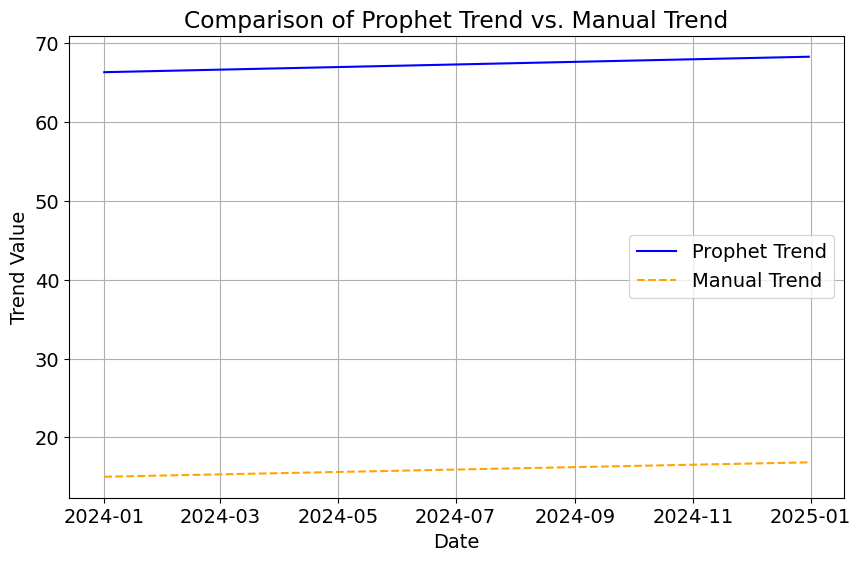

In [82]:
# Predict to get trend component
forecast = model.predict(df_test)
trend = forecast[['ds', 'trend']]

# Calculate t (time index in days)
trend['t'] = (trend['ds'] - trend['ds'].min()).dt.days

# Reconstruct trend using GT slope and intercept
trend['manual_trend'] = config["data"]["slope"] * trend['t'] + config["data"]["intercept"]

plt.figure(figsize=(10, 6))

# Plot Prophet's trend
plt.plot(trend['ds'], trend['trend'], label='Prophet Trend', color='blue')

# Plot manually reconstructed trend
plt.plot(trend['ds'], trend['manual_trend'], label='Manual Trend', color='orange', linestyle='--')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.title('Comparison of Prophet Trend vs. Manual Trend')
plt.legend()
plt.grid(True)
plt.show()

INFO  Shape of the intercept = (600,)
INFO  Intercept point estimate = 0.47769552166666673
INFO  Intercept point estimate rescaled =58.48225444680644, Intercept of groudtruth data=15


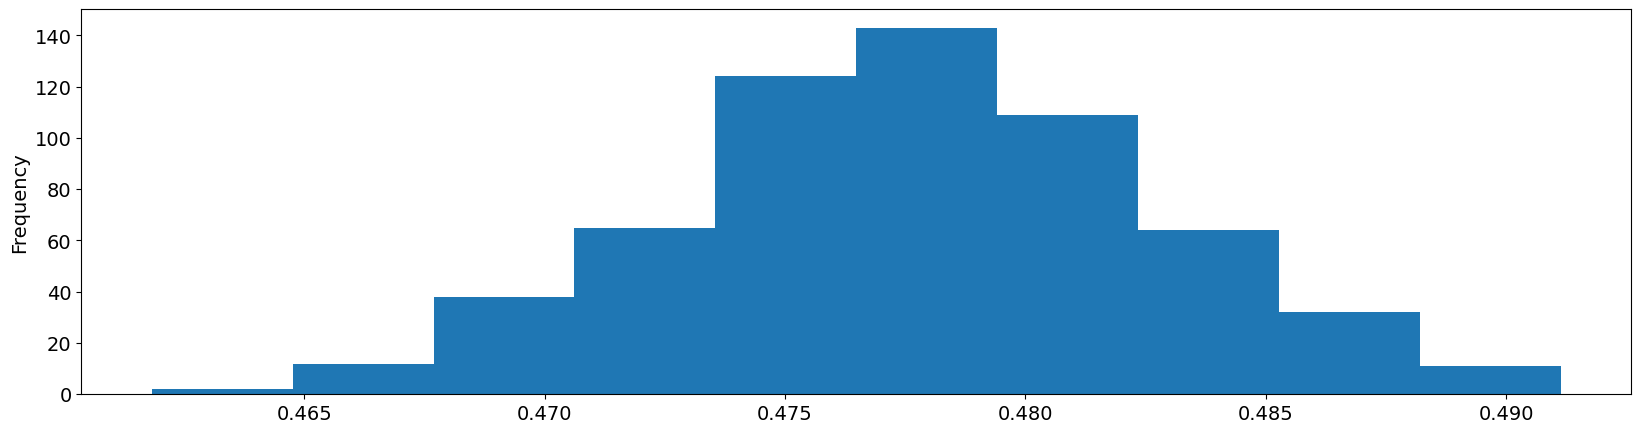

In [76]:
estimated_intercept = model.params["m"]
pd.Series(estimated_intercept).plot(kind="hist")
_LOG.info("Shape of the intercept = %s", estimated_intercept.shape)
_LOG.info("Intercept point estimate = %s", estimated_intercept.mean())
_LOG.info("Intercept point estimate rescaled =%s, Intercept of groudtruth data=%s", estimated_intercept.mean()*model.y_scale + model.y_min, config["data"]["intercept"])

INFO  Shape of the slope = (600,)
INFO  Slope point estimate = 0.14787751668416665
INFO  Slope point estimate rescaled = 7.844516509921479, Slope ground truth =0.005


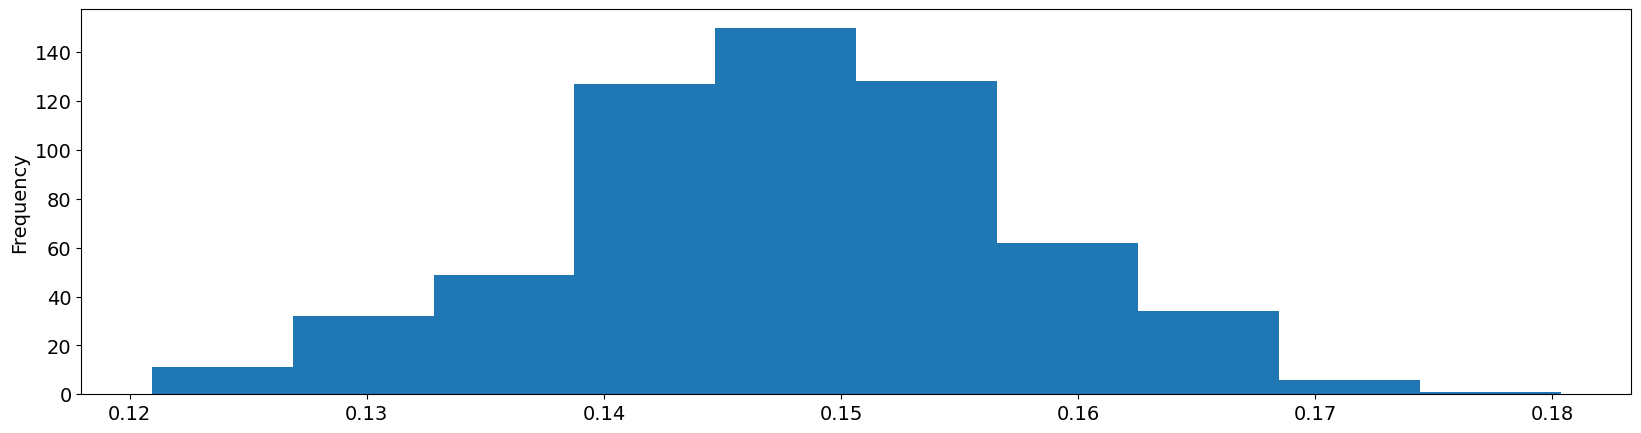

In [77]:
estimated_slope = model.params["k"]
pd.Series(estimated_slope).plot(kind="hist")
_LOG.info("Shape of the slope = %s", estimated_slope.shape)
_LOG.info("Slope point estimate = %s", estimated_slope.mean())
_LOG.info("Slope point estimate rescaled = %s, Slope ground truth =%s", estimated_slope.mean() * model.y_scale, config["data"]["slope"])

Estimated value of the autoregression coefficient is close to the ground truth.

In [15]:
# Use `regressor_coefficients()` to extract external regressors' coefficient. Unlike the other coeficients these
# already takes into account the internal scaling, thus can be directly compared to the original coefficients.
regressor_coefficients = prhu.regressor_coefficients(model)
_LOG.info(hpanda.df_to_str(regressor_coefficients, log_level=logging.INFO))
_LOG.info("True value of the autoregression coefficient = %s", config["data"]["phi"])

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,y.lag1,additive,62.375947,0.648766,0.69025,0.728626


INFO  None
INFO  True value of the autoregression coefficient = 0.7


Description:
- `weekly_delim_1` is the coefficient for the sine term
- `weekly_delim_2` is the coefficient for the cosine term
- in general the number of the Fourier coefficients is 2xN (i.e. 1 for the sine and 1 for the cosine), where N is Fourier order (i.e. 1 in our case)
- then we have 5 coefficients for 5 holidays
- and finally coefficients for the lagged feature
- each coefficient is a vector of length M (number of posterior samples)

Once the params are extracted:
- one can easily obtain a point estimate by averaging the values within a column
- compute confidence intervals using `np.quatile()`
- study the entire parameter's distribution

In [16]:
# Use this table to identify coefficients' indices in the regressors' matrix.
col_names = model.make_all_seasonality_features(df_train)[0].columns 
coefficients_df = pd.DataFrame(model.params["beta"], columns = col_names)
_LOG.info(hpanda.df_to_str(coefficients_df, log_level=logging.INFO))

,weekly_delim_1,weekly_delim_2,Christmas 2020_delim_+0,Christmas 2021_delim_+0,Christmas 2022_delim_+0,Christmas 2023_delim_+0,Christmas 2024_delim_+0,y.lag1
0,0.019549,0.10657,-0.014173,0.008866,0.050801,0.065494,-0.124408,0.127799
1,0.020927,0.103375,0.005903,0.042159,0.074555,0.052499,-0.375061,0.123104
2,0.021405,0.105651,-0.02111,-0.005996,-0.004062,0.084532,-0.367595,0.12434
,...,...,...,...,...,...,...,...
597,0.023702,0.104607,0.01885,0.040626,0.047703,0.071071,0.9808,0.122448
598,0.024231,0.102418,0.05641,0.071088,0.045821,0.109564,-0.259793,0.117841
599,0.021626,0.10019,-0.020109,0.065092,-0.017572,0.054309,-0.431339,0.12166


INFO  None


# Predict

In [17]:
start_date_filter = df["ds"] >= config["test_start_date"]
end_date_filter = df["ds"] <= config["test_end_date"]
df_test = df[start_date_filter & end_date_filter].reset_index(drop=True)
_LOG.info(hpanda.df_to_str(df_test, log_level=logging.INFO))

,ds,y,y.lag1
0,2024-01-01 00:00:00,67.852807,76.324779
1,2024-01-02 00:00:00,67.038486,67.852807
2,2024-01-03 00:00:00,70.040899,67.038486
,...,...,...
363,2024-12-29 00:00:00,78.387492,83.360033
364,2024-12-30 00:00:00,74.449184,78.387492
365,2024-12-31 00:00:00,71.713198,74.449184


INFO  None


In [18]:
forecast = model.predict(df)
forecast = forecast.merge(df, how="inner", on=["ds"])
forecast["residual"] = forecast["y"] - forecast["yhat"]
_LOG.info(hpanda.df_to_str(forecast, log_level=logging.INFO))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas 2020,Christmas 2020_lower,Christmas 2020_upper,Christmas 2021,Christmas 2021_lower,Christmas 2021_upper,Christmas 2022,Christmas 2022_lower,Christmas 2022_upper,Christmas 2023,Christmas 2023_lower,Christmas 2023_upper,Christmas 2024,Christmas 2024_lower,Christmas 2024_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,y.lag1_x,y.lag1_lower,y.lag1_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,y.lag1_y,residual
0,2020-01-02 00:00:00,58.482254,29.511541,37.511268,57.96412,59.021675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.806258,-26.415459,-23.123278,-30.289913,-31.973922,-28.469484,0.0,0.0,0.0,5.483655,5.314728,5.661283,-30.289913,-31.973922,-28.469484,0.0,0.0,0.0,33.675996,33.141753,18.493428,-0.534243
1,2020-01-03 00:00:00,58.487631,38.497338,46.540063,57.970214,59.026298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-15.863037,-17.185208,-14.495102,-20.178905,-21.300779,-18.96615,0.0,0.0,0.0,4.315869,4.087686,4.523688,-20.178905,-21.300779,-18.96615,0.0,0.0,0.0,42.624594,43.822941,33.141753,1.198347
2,2020-01-04 00:00:00,58.493008,41.719939,49.530102,57.976309,59.030922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.908069,-13.938199,-11.857053,-12.806214,-13.518193,-12.036558,0.0,0.0,0.0,-0.101855,-0.432134,0.210539,-12.806214,-13.518193,-12.036558,0.0,0.0,0.0,45.584939,48.654115,43.822941,3.069176
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,2024-12-29 00:00:00,68.283868,74.587377,82.158145,67.465946,69.029702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.041388,9.396787,10.691168,14.484268,13.613761,15.289541,0.0,0.0,0.0,-4.44288,-4.682527,-4.214646,14.484268,13.613761,15.289541,0.0,0.0,0.0,78.325256,78.387492,83.360033,0.062236
1824,2024-12-30 00:00:00,68.289244,70.244806,77.965601,67.470556,69.035817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.613645,4.899,6.290226,11.051971,10.387745,11.66642,0.0,0.0,0.0,-5.438325,-5.593718,-5.270343,11.051971,10.387745,11.66642,0.0,0.0,0.0,73.90289,74.449184,78.387492,0.546294
1825,2024-12-31 00:00:00,68.294621,70.36709,78.164817,67.475165,69.041932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.994952,5.244115,6.745523,8.333553,7.832705,8.796868,0.0,0.0,0.0,-2.338601,-2.613691,-2.043978,8.333553,7.832705,8.796868,0.0,0.0,0.0,74.289573,71.713198,74.449184,-2.576375


INFO  None


# Analyze the results

In [20]:
ins_forecast = forecast[forecast["ds"]<=config["train_end_date"]]
ins_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas 2020,Christmas 2020_lower,Christmas 2020_upper,Christmas 2021,...,y.lag1_x,y.lag1_lower,y.lag1_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,y.lag1_y,residual
1455,2023-12-27,66.305264,70.875151,78.173303,65.769617,66.794126,0.0,0.0,0.0,0.0,...,5.564740,5.230299,5.874120,0.0,0.0,0.0,74.392142,75.593189,70.437866,1.201047
1456,2023-12-28,66.310641,77.214069,84.736136,65.774227,66.800110,0.0,0.0,0.0,0.0,...,9.123203,8.574897,9.630420,0.0,0.0,0.0,80.917499,81.430431,75.593189,0.512932
1457,2023-12-29,66.316018,79.739555,87.753117,65.778836,66.806095,0.0,0.0,0.0,0.0,...,13.152360,12.361901,13.883583,0.0,0.0,0.0,83.784246,86.189145,81.430431,2.404898
1458,2023-12-30,66.321394,78.974666,86.667060,65.783446,66.812110,0.0,0.0,0.0,0.0,...,16.437062,15.449192,17.350903,0.0,0.0,0.0,82.656602,83.890760,86.189145,1.234159
1459,2023-12-31,66.326771,72.816846,80.531339,65.788055,66.818140,0.0,0.0,0.0,0.0,...,14.850602,13.958079,15.676242,0.0,0.0,0.0,76.734494,76.324779,83.890760,-0.409714


<Axes: >

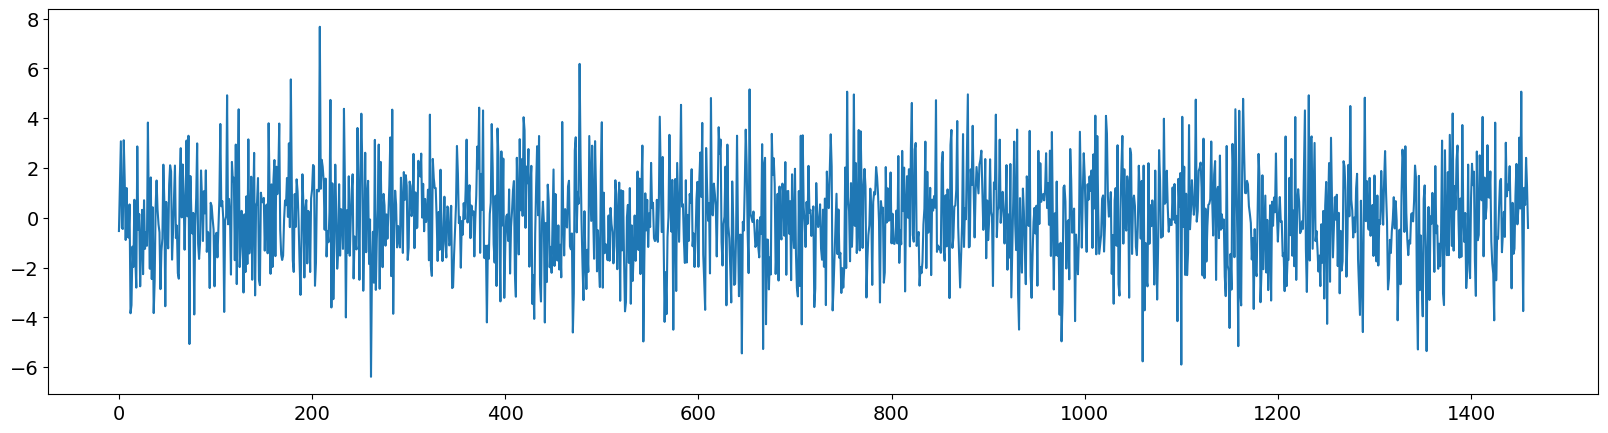

In [21]:
ins_forecast["residual"].plot()

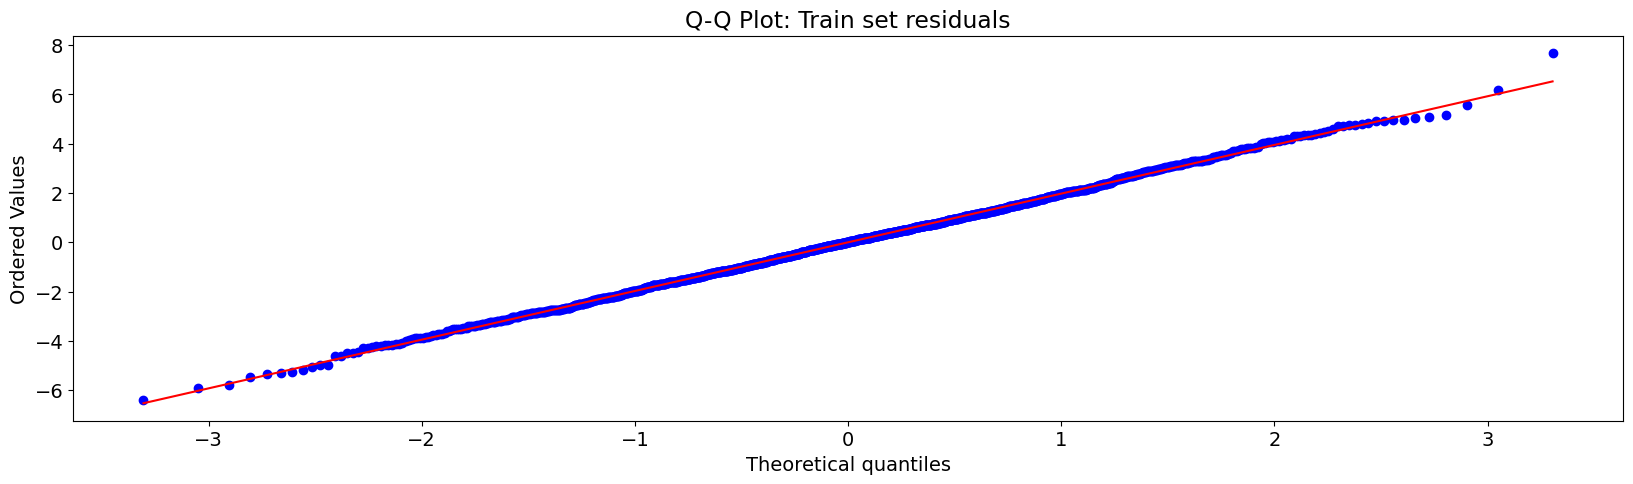

In [22]:
stats.probplot(ins_forecast["residual"], dist="norm", plot=plt)
plt.title("Q-Q Plot: Train set residuals")
plt.show()

Text(0.5, 1.0, 'Observed vs predicted data, train set')

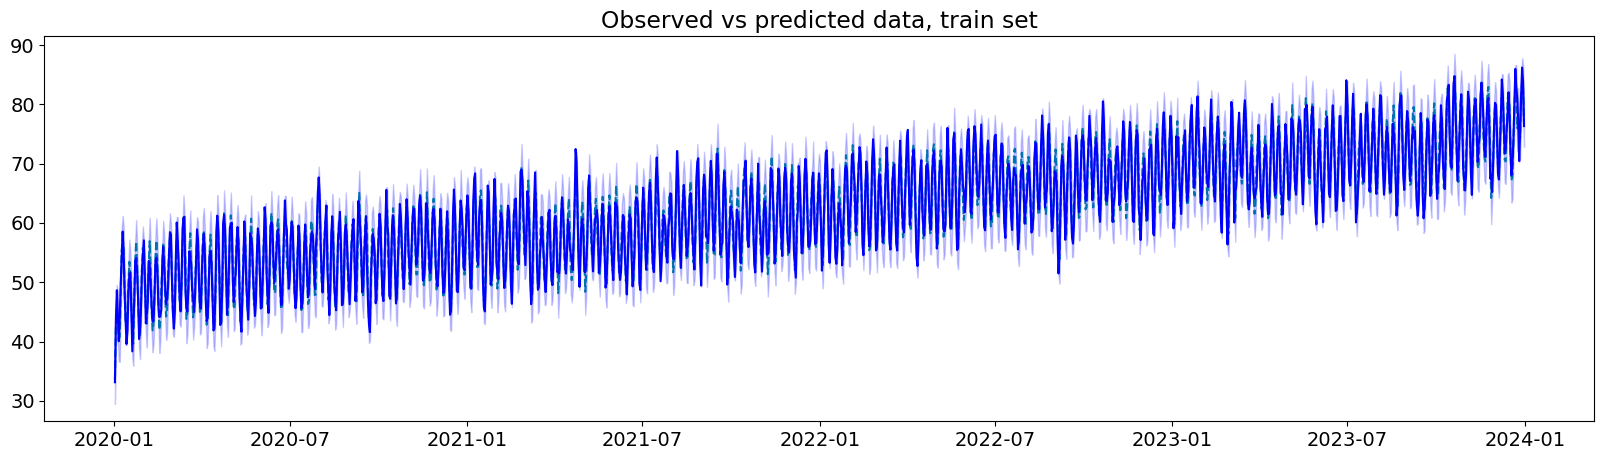

In [23]:
plt.plot(ins_forecast["ds"], ins_forecast["yhat"], label="Point Estimate", ls='--', c='#0072B2')
plt.plot(ins_forecast["ds"], ins_forecast["y"], label="Observed data", color="blue")

# Plot confidence/prediction intervals
plt.fill_between(
    ins_forecast["ds"],
    ins_forecast["yhat_lower"],
    ins_forecast["yhat_upper"],
    color="blue",
    alpha=0.2,
    label="Confidence Interval",
)
plt.title("Observed vs predicted data, train set")

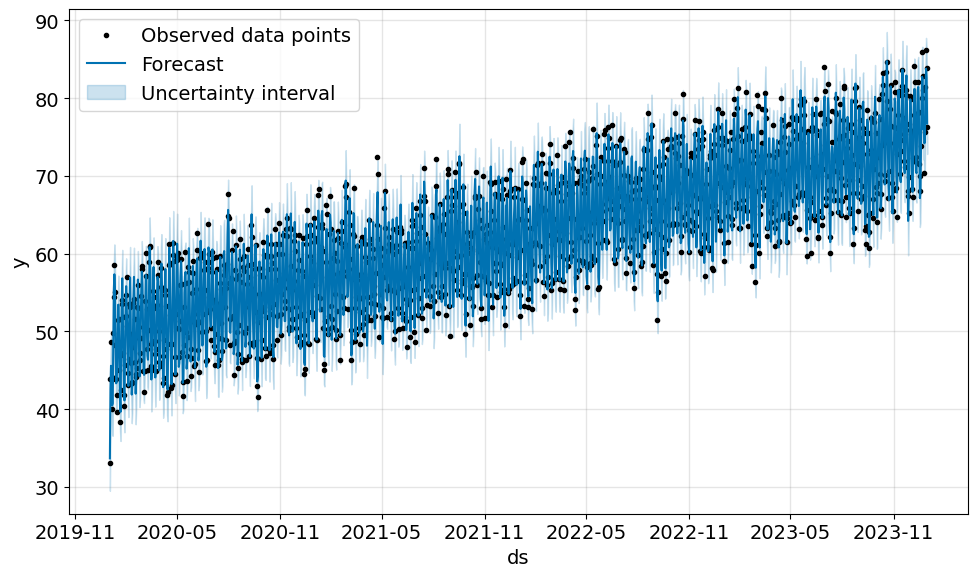

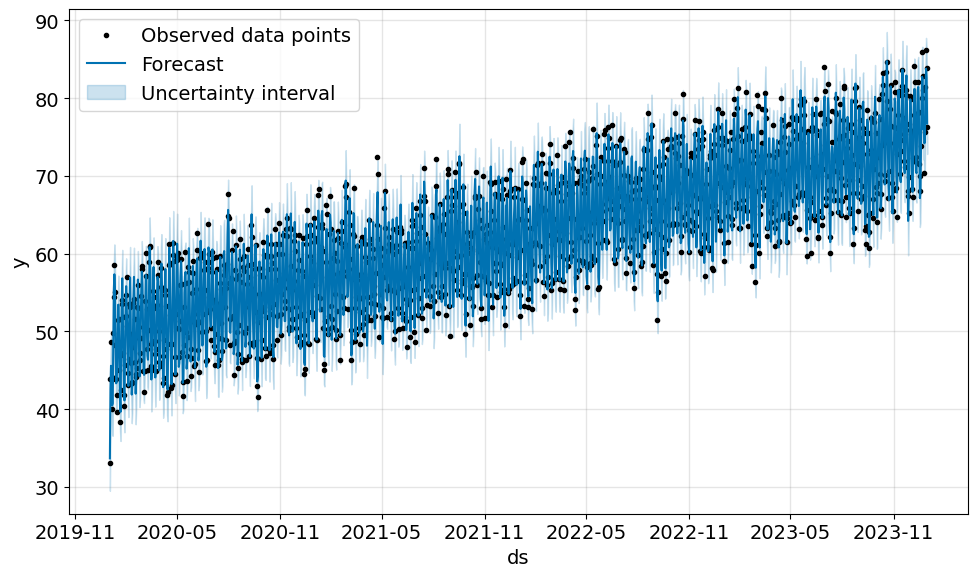

In [24]:
model.plot(ins_forecast, include_legend=True)

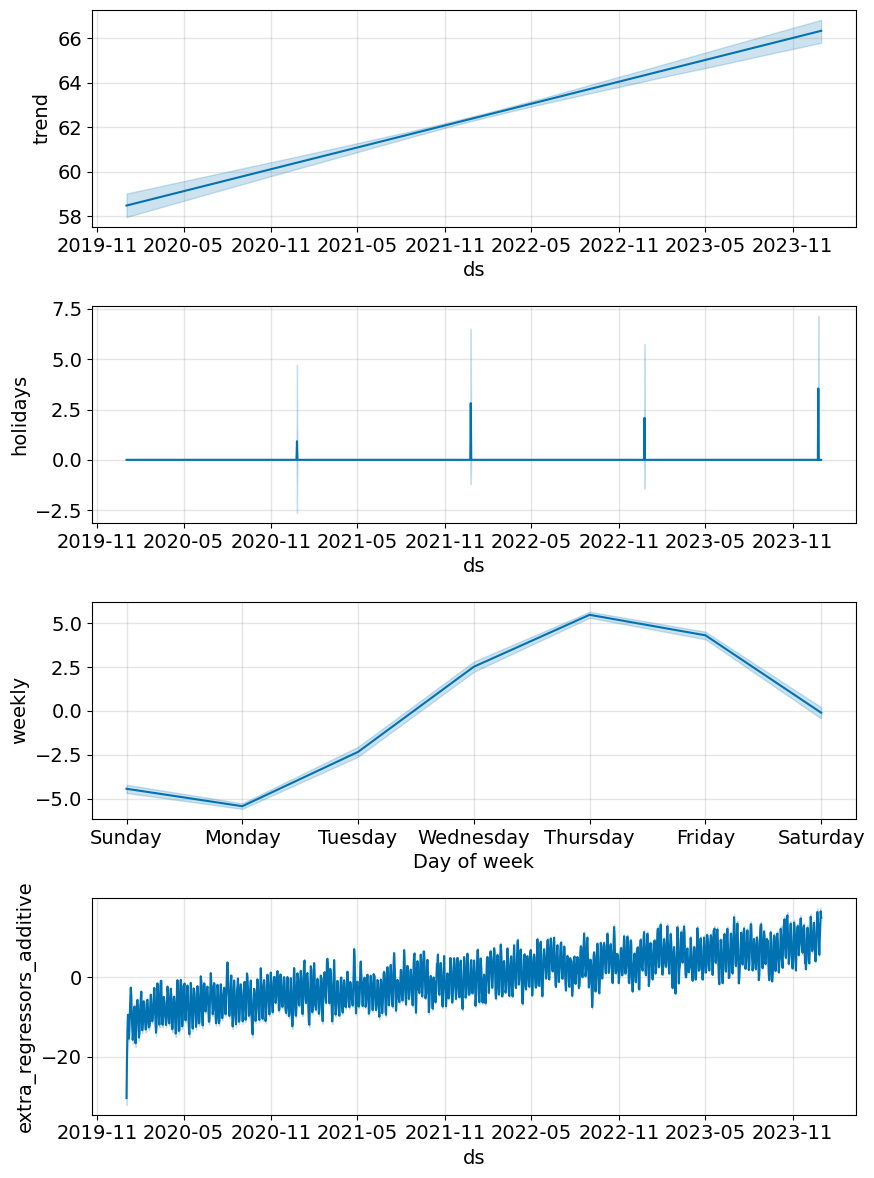

In [25]:
fig2 = model.plot_components(ins_forecast)

In [26]:
oos_forecast = forecast[forecast["ds"]>=config["test_start_date"]]
oos_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas 2020,Christmas 2020_lower,Christmas 2020_upper,Christmas 2021,...,y.lag1_x,y.lag1_lower,y.lag1_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,y.lag1_y,residual
1821,2024-12-27,68.273114,83.433177,90.945851,67.456727,69.017472,0.0,0.0,0.0,0.0,...,14.761196,13.874046,15.581865,0.0,0.0,0.0,87.350179,86.611489,83.761234,-0.738691
1822,2024-12-28,68.278491,80.893979,88.895821,67.461336,69.023587,0.0,0.0,0.0,0.0,...,16.728585,15.723195,17.658634,0.0,0.0,0.0,84.905222,83.360033,86.611489,-1.545188
1823,2024-12-29,68.283868,74.587377,82.158145,67.465946,69.029702,0.0,0.0,0.0,0.0,...,14.484268,13.613761,15.289541,0.0,0.0,0.0,78.325256,78.387492,83.360033,0.062236
1824,2024-12-30,68.289244,70.244806,77.965601,67.470556,69.035817,0.0,0.0,0.0,0.0,...,11.051971,10.387745,11.666420,0.0,0.0,0.0,73.902890,74.449184,78.387492,0.546294
1825,2024-12-31,68.294621,70.367090,78.164817,67.475165,69.041932,0.0,0.0,0.0,0.0,...,8.333553,7.832705,8.796868,0.0,0.0,0.0,74.289573,71.713198,74.449184,-2.576375


Text(0.5, 1.0, 'Observed vs predicted data, test set')

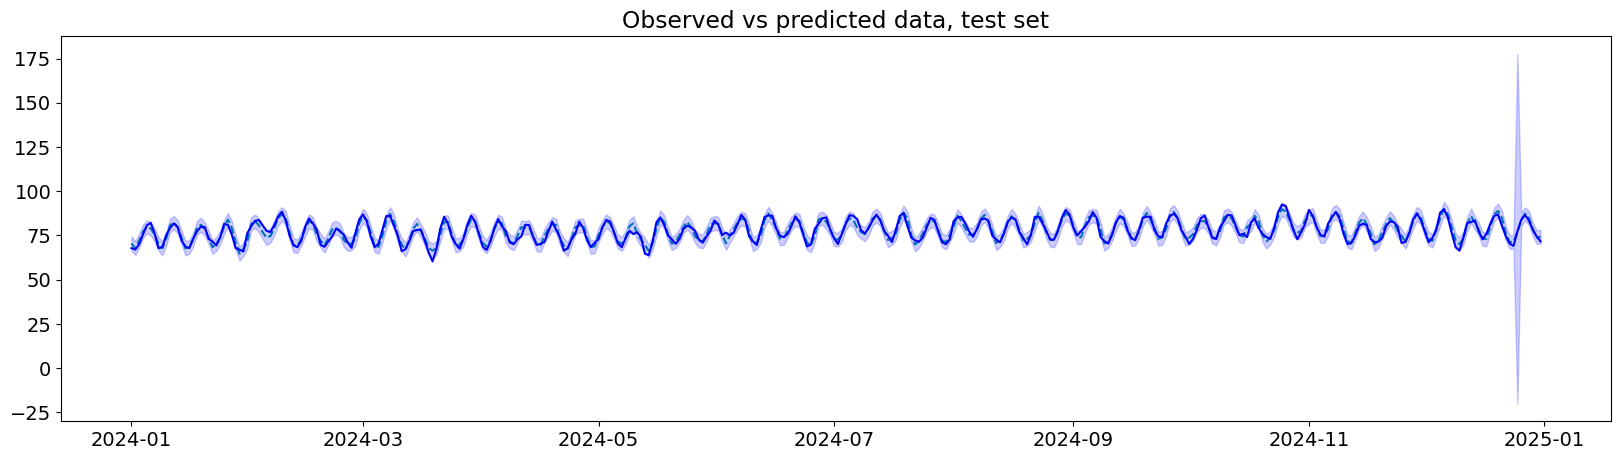

In [27]:
plt.plot(oos_forecast["ds"], oos_forecast["yhat"], label="Point Estimate", ls='--', c='#0072B2')
plt.plot(oos_forecast["ds"], oos_forecast["y"], label="Observed data", color="blue")

# Plot confidence/prediction intervals
plt.fill_between(
    oos_forecast["ds"],
    oos_forecast["yhat_lower"],
    oos_forecast["yhat_upper"],
    color="blue",
    alpha=0.2,
    label="Confidence Interval",
)
plt.title("Observed vs predicted data, test set")

In [57]:
from prophet.plot import plot_plotly, plot_components_plotly

In [66]:
forecast = model.predict(df)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas 2020,Christmas 2020_lower,Christmas 2020_upper,Christmas 2021,...,weekly,weekly_lower,weekly_upper,y.lag1,y.lag1_lower,y.lag1_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1821,2024-12-27,68.273114,83.273845,91.375150,67.456727,69.017472,0.0,0.0,0.0,0.0,...,4.315869,4.087686,4.523688,14.761196,13.874046,15.581865,0.0,0.0,0.0,87.350179
1822,2024-12-28,68.278491,81.130641,88.908063,67.461336,69.023587,0.0,0.0,0.0,0.0,...,-0.101855,-0.432134,0.210539,16.728585,15.723195,17.658634,0.0,0.0,0.0,84.905222
1823,2024-12-29,68.283868,74.484618,82.113420,67.465946,69.029702,0.0,0.0,0.0,0.0,...,-4.442880,-4.682527,-4.214646,14.484268,13.613761,15.289541,0.0,0.0,0.0,78.325256
1824,2024-12-30,68.289244,70.055628,77.674137,67.470556,69.035817,0.0,0.0,0.0,0.0,...,-5.438325,-5.593718,-5.270343,11.051971,10.387745,11.666420,0.0,0.0,0.0,73.902890
1825,2024-12-31,68.294621,70.583969,77.822010,67.475165,69.041932,0.0,0.0,0.0,0.0,...,-2.338601,-2.613691,-2.043978,8.333553,7.832705,8.796868,0.0,0.0,0.0,74.289573


In [60]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
361,2024-12-27,87.350179,83.526260,91.118547
362,2024-12-28,84.905222,81.170169,88.858933
363,2024-12-29,78.325256,74.571310,82.193079
364,2024-12-30,73.902890,70.113492,77.810171
365,2024-12-31,74.289573,70.216258,78.271136


In [61]:
df_test.tail()

,ds,y,y.lag1
361,2024-12-27,86.611489,83.761234
362,2024-12-28,83.360033,86.611489
363,2024-12-29,78.387492,83.360033
364,2024-12-30,74.449184,78.387492
365,2024-12-31,71.713198,74.449184


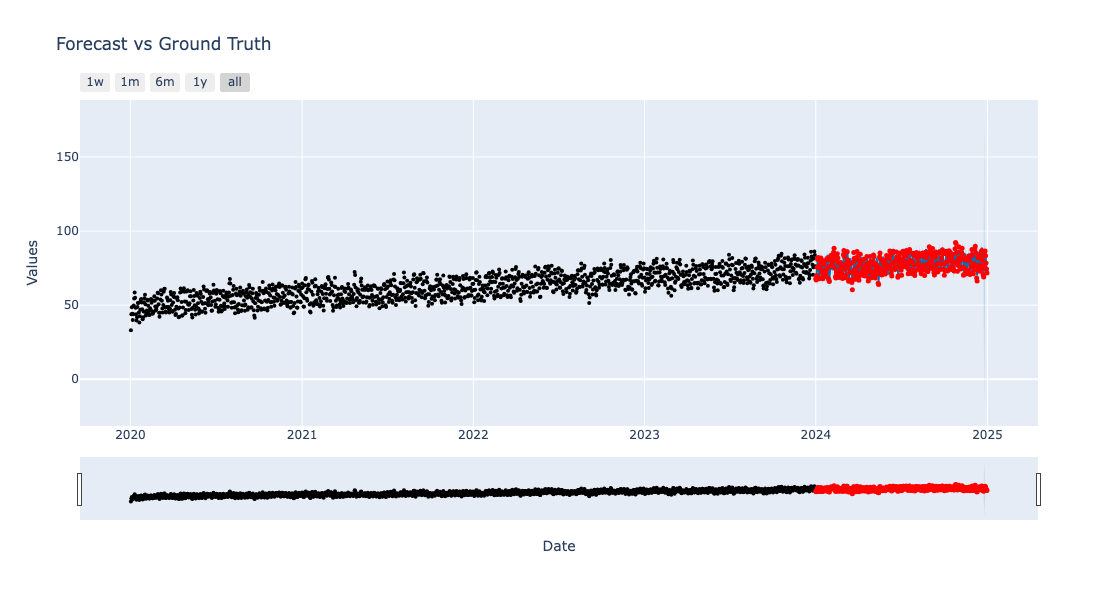

In [64]:
from prophet.plot import plot_plotly
import plotly.graph_objects as go

# Create Prophet's interactive plot
fig = plot_plotly(model, forecast)

# Add ground truth (actual values)
fig.add_trace(
    go.Scatter(
        x=df_test['ds'],
        y=df_test['y'],
        mode='markers',
        name='Ground Truth',
        marker=dict(color='red', size=5)
    )
)

# Update layout
fig.update_layout(
    title="Forecast vs Ground Truth",
    xaxis_title="Date",
    yaxis_title="Values",
    legend=dict(orientation="h", y=-0.2),
)

# Show the plot
fig.show()


# Performance metrics

Prophet provides performance metric calculation only on the cross validation data. To test the performance of prophet model on test split we will be using sklearn metrics.

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate metrics
mae = mean_absolute_error(forecast['y'], forecast['yhat'])
rmse = mean_squared_error(forecast['y'], forecast['yhat'])
mape = (abs(forecast['y'] - forecast['yhat']) / forecast['y']).mean() * 100

_LOG.info("MAE=%s, RMSE=%s, MAPE=%s", mae, rmse, mape)

INFO  MAE=1.5741362078086365, RMSE=3.91703472994083, MAPE=2.4726391547194795


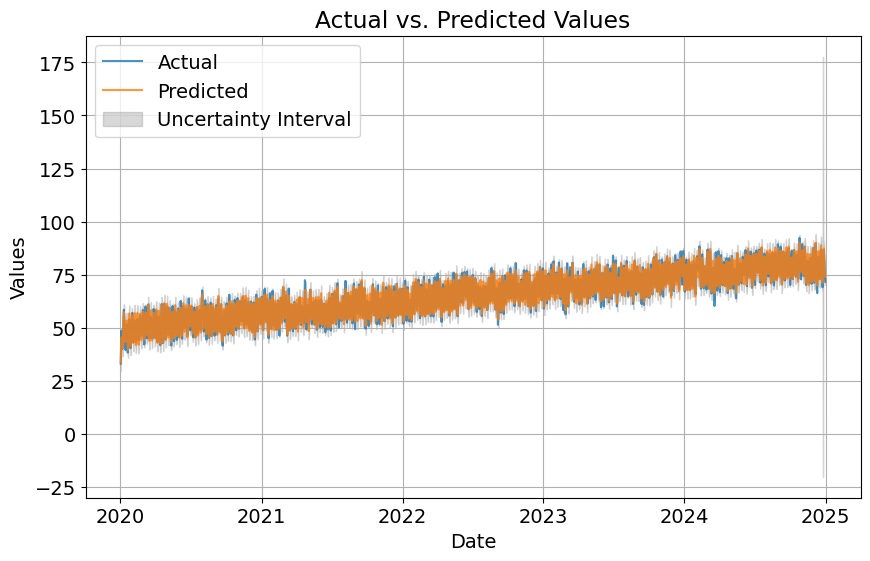

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['y'], label='Actual', alpha=0.8)
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', alpha=0.8)
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='gray',
    alpha=0.3,
    label='Uncertainty Interval'
)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


# Cross Validation

- Sliding Window Approach:

The historical dataset is split into multiple training and testing sets using a sliding window approach.
Each training set ends at a specific cutoff date, and the model is tested on the subsequent data.

- Parameters:

    - initial: The size of the initial training period (e.g., 3 years).
    - horizon: The forecast horizon for which predictions are made (e.g., 30 days).
    - period: The spacing between cutoff dates (e.g., 90 days).
This setup generates overlapping training and testing periods, simulating how the model performs when trained on different subsets of the data.

In [31]:
from prophet.diagnostics import cross_validation, performance_metrics

In [33]:
df_cv = cross_validation(
    model=model,
    # Use 2 years as initial training period.
    initial='730 days',
    # Move rolling window every 180 days.
    period='180 days',     
    horizon='365 days'
)


INFO  Making 3 forecasts with cutoffs between 2022-01-05 00:00:00 and 2022-12-31 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

17:44:27 - cmdstanpy - INFO - CmdStan start processing


INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:44:38 - cmdstanpy - INFO - CmdStan done processing.



INFO  CmdStan done processing.


17:44:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_gl

WARNING Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0

17:44:39 - cmdstanpy - INFO - CmdStan start processing


INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:44:52 - cmdstanpy - INFO - CmdStan done processing.



INFO  CmdStan done processing.


17:44:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matr

WARNING Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variabl

17:44:53 - cmdstanpy - INFO - CmdStan start processing


INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:45:11 - cmdstanpy - INFO - CmdStan done processing.



INFO  CmdStan done processing.


17:45:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scal

WARNING Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must b

17:45:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (0.7%)
	Chain 2 had 16 iterations at max treedepth (10.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


WARNING Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (0.7%)
	Chain 2 had 16 iterations at max treedepth (10.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [40]:
df_perf = performance_metrics(df_cv)
_LOG.info(hpanda.df_to_str(df_perf, log_level=logging.INFO))

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days 00:00:00,4.660767,2.158881,1.717476,0.026228,0.022973,0.026236,0.93578
1,38 days 00:00:00,4.625136,2.150613,1.722002,0.026215,0.022973,0.026246,0.941896
2,39 days 00:00:00,4.484565,2.117679,1.689287,0.02572,0.022917,0.025751,0.944954
,...,...,...,...,...,...,...,...
326,363 days 00:00:00,3.852974,1.962899,1.55772,0.022169,0.01868,0.022104,0.944954
327,364 days 00:00:00,3.723991,1.929764,1.522045,0.021587,0.016913,0.021537,0.944954
328,365 days 00:00:00,3.647932,1.909956,1.494331,0.021132,0.016204,0.0211,0.944954


INFO  None


In [41]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-06,66.385200,62.561617,70.220528,66.970390,2022-01-05
1,2022-01-07,69.699724,65.959533,73.890207,71.847992,2022-01-05
2,2022-01-08,68.628493,64.740825,72.843460,72.231540,2022-01-05
3,2022-01-09,64.534967,60.694635,68.185419,66.863977,2022-01-05
4,2022-01-10,59.859572,56.000209,63.517351,56.392094,2022-01-05


In [37]:
from prophet.plot import plot_cross_validation_metric

/venv/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/venv/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


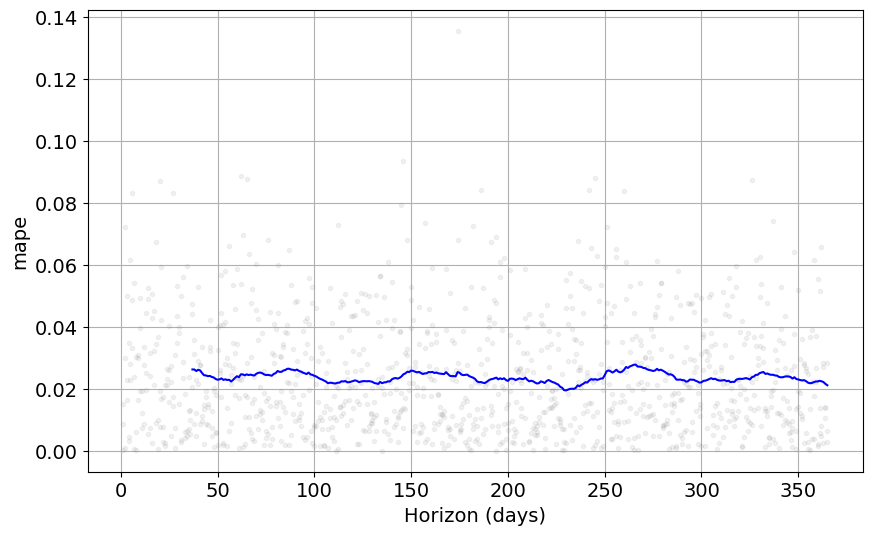

In [38]:
# Plot Mean Absolute Percentage Error (MAPE)
fig = plot_cross_validation_metric(df_cv, metric='mape')